In [11]:
import  torch;
import  matplotlib.pyplot   as plt;
import  seaborn;
from    typing      import  List, Dict, Tuple;
import  numpy;

### Model Class

Define a class that can describe the right-hand side of a DDE, 
$$x'(t) = F(x(t), y(t), t) $$

In our case, the right-hand side we want to learn will be
1. $F(x, y, t) = x(1 - y) $
2. $F(x, y, t) = \sin{x}$

The `MODEL` class defines an object that can act like the function $F$.

In [12]:
from  MODEL     import MODEL;

### DDE Solver

This is an algorithm to solve a DDE of the following form:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$

We find an approximate solution using a forward euler solver for DDEs.

In [13]:
from    Solver  import Forward_Euler    as DDE_Solver;

In [14]:
import  torch;
import  matplotlib.pyplot   as plt;
import  seaborn;
from    typing      import  List, Dict, Tuple;
import  numpy;

from    Solver  import Forward_Euler    as DDE_Solver;
from    MODEL   import MODEL;


### Generate True solution

Generate the true solution and plot it!

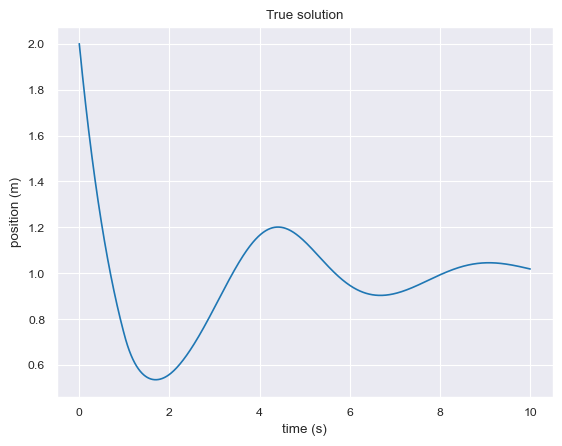

In [15]:
# Set up an object to represent the vector field that we want to learn
F_True          = MODEL(c_0 = 1.0, c_1 = 1.0);
x_0_True        = torch.tensor([2.0]);
tau_True        = torch.tensor(1.0);
T_True          = torch.tensor(10.0);
x_trajectory_True, t_trajectory_True  = DDE_Solver(F = F_True, x_0 = x_0_True, tau = tau_True, T = T_True);

# Now, plot the true trajectory.
seaborn.set_context(context     = "paper");
seaborn.set_style(  style       = "darkgrid");
palette : str = "winter";
seaborn.lineplot(x = t_trajectory_True.detach().numpy(), y = x_trajectory_True.reshape(-1).detach().numpy(), palette = palette);
plt.xlabel("time (s)");
plt.ylabel("position (m)");
plt.title("True solution");

### NDDE class

Here we define the `NDDE_1D` class. This class acts as a wrapper around a `MODEL` object. Recall that a `MODEL` object acts like the function $F$ in the following DDE:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$
The `NDDE_1D` class accepts a `MODEL`. Its forward method solves the implied DDE on the interval $[0, T]$ and then returns the result.

In [16]:
from    NDDE    import NDDE_1D;

### Interpolate, Loss

These are functions which we need to run the Epochs. Currently, this consists of `loss_fn` and `Interpolate_Trajectory`. The former defines the loss we try to minimize while the latter allows us to interpolate the solution of a DDE. The latter is needed because $tau$ changes as we train the model (and chaning tau changes the step size, which changes the times at which the DDE solver finds solutions to the DDE).

In [17]:
from    Interpolate         import  Interpolate_Trajectory;
from    Loss                import  MSE_Loss        as Loss_Fn;

### Setup, train the Model 


In [18]:
from    Train   import Train_2_Param;

# Set up a NDDE_1D object. We will try to train the enclosed model to match the one we used to generate the above plot.
Model       = MODEL(c_0 = 2.0, c_1 = 2.0);
DDE_Module  = NDDE_1D(Model);

# Pick a starting position, tau, and x_0
tau     = torch.tensor(2.0,     requires_grad = True);
x_0     = torch.clone(x_0_True).requires_grad_(True);
T       = torch.clone(T_True).requires_grad_(False);

# Select the optimizer, number of epochs.
Param_List  : List  = list(Model.parameters()) + [tau];
Optimizer           = torch.optim.Adam(Param_List, lr = 0.1);
N_Epochs    : int   = 1000;

# Now, run the epochs!
History_Dict, Final_Predicted_Trajectory = Train_2_Param(
                                                N_Epochs            = N_Epochs, 
                                                DDE_Module          = DDE_Module, 
                                                tau                 = tau, 
                                                x_0                 = x_0, 
                                                T                   = T, 
                                                x_trajectory_True   = x_trajectory_True, 
                                                t_trajectory_True   = t_trajectory_True, 
                                                Optimizer           = Optimizer);
Loss_History    : torch.Tensor              = History_Dict["Loss"];
Tau_History     : torch.Tensor              = History_Dict["tau"];

   0:   Loss = 1.56273  | tau = 1.90000  | grad tau =   2.15335  | Params = 1.90000, 1.90000  | grad Params = 146.20912, 198.08644
  10:   Loss = 0.48933  | tau = 1.36234  | grad tau =  50.81523  | Params = 1.35845, 1.35844  | grad Params = 774.80139, 1278.56323
  20:   Loss = 0.08005  | tau = 1.16231  | grad tau =   2.67334  | Params = 1.15995, 1.15970  | grad Params = 306.03745, 615.41644
  30:   Loss = 0.01897  | tau = 1.08513  | grad tau = -17.55883  | Params = 1.08329, 1.08292  | grad Params = 267.45898, 599.69000
converged after 37 epochs
Final values:
tau = 1.06371, c_0 = 1.06194, c_1 = 1.06152


### Plot results 

We plot the loss history, final vs true trajectory, and the loss function for fixed parameter values as a function of $\tau$

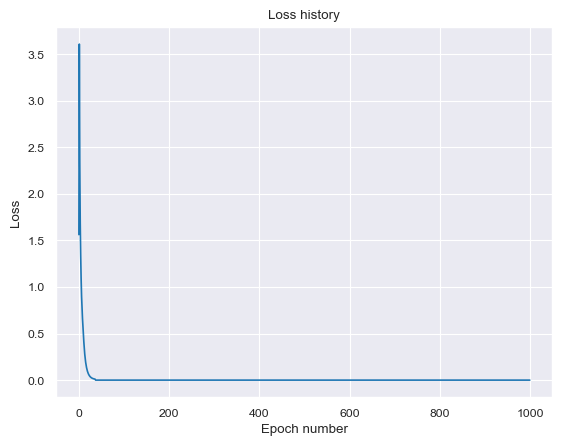

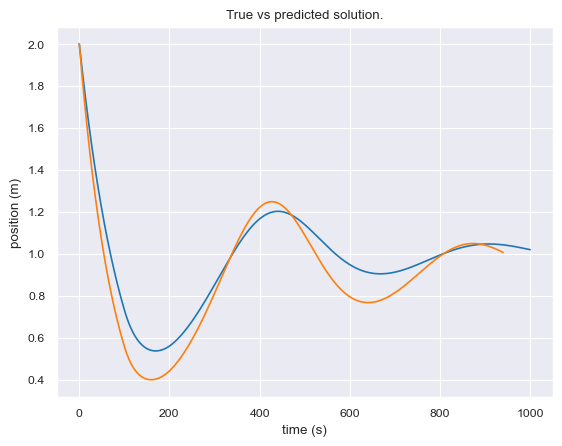

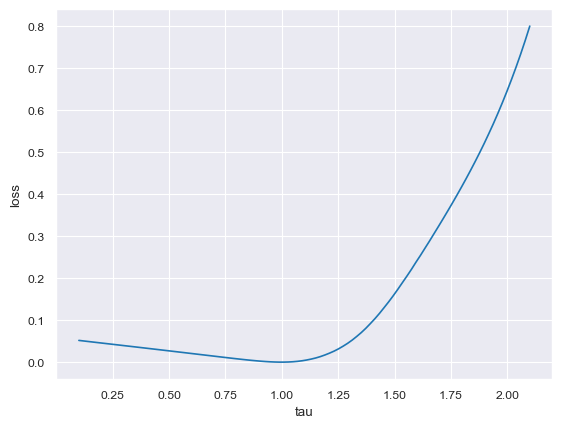

In [19]:
####################################################################################################
# Lost loss history
plt.figure(0);
plt.plot(Loss_History.detach().numpy());
plt.xlabel("Epoch number");
plt.ylabel("Loss");
plt.title("Loss history");



####################################################################################################
# Plot final trajectories
plt.figure(1);
plt.plot(x_trajectory_True[0].detach().numpy(), label = "true");
plt.plot(Final_Predicted_Trajectory[0].detach().numpy(), label = "discovered");
plt.xlabel("time (s)");
plt.ylabel("position (m)");
plt.title("True vs predicted solution.");



####################################################################################################
# Plot loss as a function of tau

# Build initial model
G : MODEL = MODEL(c_0 = 1.0, c_1 = 1.0);

# Set up a grid of tau values. We will find the loss at each one.
N_Steps : int = 100;
grid_tau = torch.linspace(0.1, 2.1, steps = N_Steps, requires_grad = True);
loss_tau = torch.zeros(N_Steps);

for i in range(N_Steps):
    # Find predictions for ith tau value.
    Predictions_i : torch.Tensor = DDE_Solver(G, x_0, grid_tau[i], T)[0];

    # Interpolate true solution on the time step grid for this solution.
    N_i : int = Predictions_i.shape[1];
    Targets_i = Interpolate_Trajectory(x_trajectory_True, t_trajectory_True, N_i);
    
    # Compute loss
    loss_tau[i] = Loss_Fn(Predictions_i, Targets_i, grid_tau[i]);

# Plot!
plt.figure(2);
seaborn.lineplot(x = grid_tau.detach().numpy(), y = loss_tau.detach().numpy());
plt.xlabel("tau");
plt.ylabel("loss");